In [1]:
from imagegrains import data_loader, segmentation_helper
from cellpose import models
from pathlib import Path

import os, warnings
warnings.filterwarnings("ignore")

## Download pre-trained models and demo data  
If you have not donwloaded the pre-trained models and demo data yet from github, please see notebook **1_image_segmentation**. If you want to run on your own data, you can set the path manually in the next cell.

In [2]:
#set path to predicted masks (segmentation model output)
data_path = "F:/cellpose/K1/"

This notebook will try to use segementation results from the notebook **1_image_segmentation**.

In [3]:
download_path = Path.home().joinpath('imagegrains')
data_path = download_path.joinpath('demo_data','K1').as_posix()
print("Using files from:",data_path)

Using files from: C:/Users/Mair/imagegrains/demo_data/K1


To use the demo files, please run the following cell.

In [4]:
model_path = f'{download_path}/models/full_set_1.170223'
model_id = 'full_set_1'

## Combine grains from two inferences with different scales   
First, we will create directories for the two predictions at different scales.

In [5]:
#Set path1 to small masks
path1 = f'{data_path}/K1_small'
os.makedirs(path1,exist_ok=True)
#Set path2 to large masks
path2 = f'{data_path}/K1_large'
os.makedirs(path2,exist_ok=True)

Now, we will run inference with two different scales. To do so, 
we will provide different expected median diameters in px for the `diameter` parameter (the default value for the `nuclei` model is `17`). The model will rescale the images accordingly.

In [6]:
#initialiize the model
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

#run the segmentation for the small grains (with diameter = None)
print('Segment with diameter = 0:')
segmentation_helper.predict_folder(data_path,image_format='jpg',diameter=None,
        return_results=False,model=model,save_masks=True,tar_dir=path1,mute =True,model_id='full_set_1');

#re-run the segmentation for the large grains (with a given diameter that is >> 17)
large_diam = 133
print(f'Segment with diameter = {large_diam}:')
segmentation_helper.predict_folder(data_path,image_format='jpg',diameter=large_diam,
        return_results=False,model=model,save_masks=True,tar_dir=path2,mute =True,model_id='full_set_1');

Segment with diameter = 0:


C:/Users/Mair/imagegrains/demo_data/K1: 100%|██████████| 1/1 [00:36<00:00, 36.23s/image]


Segment with diameter = 133:


C:/Users/Mair/imagegrains/demo_data/K1: 100%|██████████| 1/1 [00:10<00:00, 10.52s/image]


In [7]:
#load images and prediction masks
imgs,_,_ = data_loader.dataset_loader(data_path)
_,_,preds1= data_loader.dataset_loader(path1)
_,_,preds2= data_loader.dataset_loader(path2)

#set filters
filters = {'edge':[False,.1],'px_cutoff':[True,12]}

Combine the two precdictions with a simple threshold approach. This will use all grains < `threshold` from `path1` and all grains > `threshold` from `path2`. The combination is done on a single pixel basis and in cas of overlap, priority is given to the larger grain (from `path2`). By default, the `equivalent_diameter_area` from [scikit-image.measure](<https://scikit-image.org/docs/stable/api/skimage.measure.html>) is used.


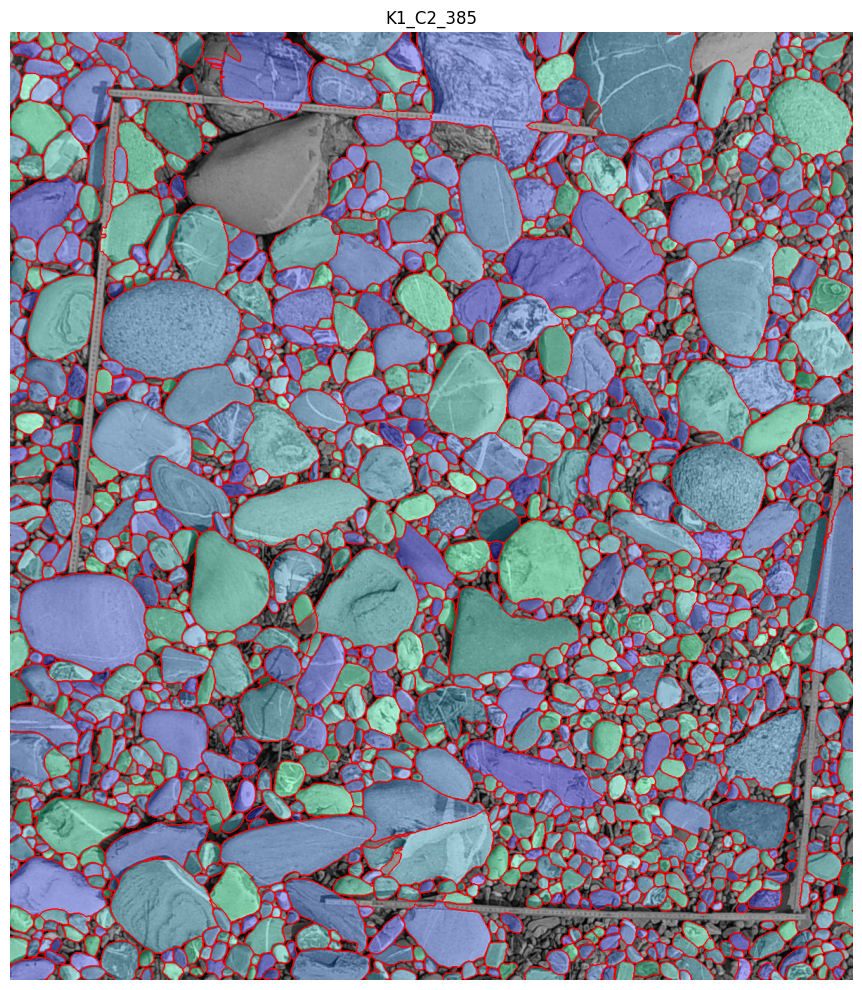

In [8]:
size_metric ='equivalent_diameter_area'
threshold = 175

segmentation_helper.combine_preds(preds1,preds2,imgs,
              model_id=model_id,filters=filters,threshold=threshold)